# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [ ]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- **Да**

Класс без поиска шага - nostep_GradientBusting, GradientBusting - с оптимальным


In [ ]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self._n_estimators = n_estimators
        self._max_depth = max_depth
        self._learning_rate = learning_rate
        self._estimators = [{'tree':DecisionTreeRegressor(max_depth=max_depth), 'weight':None} for i in range(n_estimators)]
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        y_new = y
        for i in range(self._n_estimators):
            y_new = y_new - self._fit_predict_tree(i, x, y_new)
        return self
 
    def _fit_predict_tree(self, i, x, y):
        self._estimators[i]['tree'] = self._estimators[i]['tree'].fit(x, y)
        #optimized = minimize(lambda g: mean_squared_error(y_true=y, y_pred=(g*self._estimators[i]['tree'].predict(x))), x0=0)
        optimized = minimize(lambda g: np.sum((y-g*self._estimators[i]['tree'].predict(x)) ** 2), x0=0)
        self._estimators[i]['weight'] = optimized['x'][0]
        return self._estimators[i]['weight'] * self._learning_rate * self._estimators[i]['tree'].predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.array(sum([estimator['tree'].predict(x)*estimator['weight']*self._learning_rate for estimator in self._estimators]))
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [ ]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
 
rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)
 
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.635844078917064

In [ ]:
np.random.seed(19052019)

my_gb = GradientBoosting(640, 6)
my_gb.fit(X_train, y_train)

#a = my_gb.predict(X_train)

mean_squared_error(y_train, my_gb.predict(X_train))
mean_squared_error(y_test, my_gb.predict(X_test))

In [ ]:
print(mean_squared_error(y_train, my_gb.predict(X_train)))
mean_squared_error(y_test, my_gb.predict(X_test))

2.60067289828015e-07


10.215989444695024

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(19052019)

gbs_std = {(i, j):GradientBoosting(i, j).fit(X_train, y_train) for j in range(1, 10) for i in range(50, 600, 25)}
gbs_01 = {(i, j):GradientBoosting(i, j, learning_rate=0.01).fit(X_train, y_train) for j in range(1, 10) for i in range(50, 600, 25)}
gbs_095 = {(i, j):GradientBoosting(i, j, learning_rate=0.095).fit(X_train, y_train) for j in range(1, 10) for i in range(50, 600, 25)}

In [ ]:
gbs_means, gbs_01_means, gbs_095_means = {}, {}, { }
for key in gbs_std.keys():
  gbs_means[key] =  mean_squared_error(y_test, gbs_std[key].predict(X_test))
  gbs_01_means[key] =  mean_squared_error(y_test, gbs_01[key].predict(X_test))
  gbs_095_means[key] =  mean_squared_error(y_test, gbs_095[key].predict(X_test))

In [ ]:
score_df_std = pd.DataFrame([[list(gbs_means.values())[i], list(gbs_means.keys())[i][0], list(gbs_means.keys())[i][1]] for i in range(len(gbs_means))], columns=['score', 'n_estimators', 'max_depth'])
score_df_std

score  n_estimators  max_depth
0    18.879720            50          1
1    18.271062            75          1
2    18.303641           100          1
3    18.536175           125          1
4    19.155948           150          1
..         ...           ...        ...
193  11.700587           475          9
194  11.163413           500          9
195  11.668197           525          9
196  11.871367           550          9
197  11.847072           575          9

[198 rows x 3 columns]

Text(0.5, 1.0, 'Learning rate = 0.01')

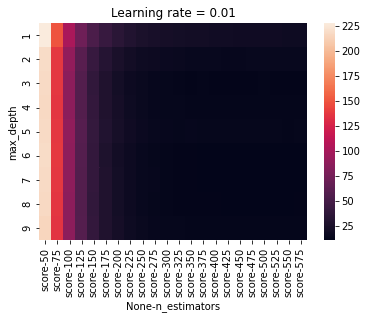

In [ ]:
score_df_01 = pd.DataFrame([[list(gbs_01_means.values())[i], list(gbs_01_means.keys())[i][0], list(gbs_01_means.keys())[i][1]] for i in range(len(gbs_01_means))], columns=['score', 'n_estimators', 'max_depth'])

heatdf = pd.pivot(score_df_01, columns=['n_estimators'], index=['max_depth'], values=['score'])
heatdf
fig = sns.heatmap(heatdf)
plt.title(f'Learning rate = 0.01')

Text(0.5, 1.0, 'Learning rate = 0.095')

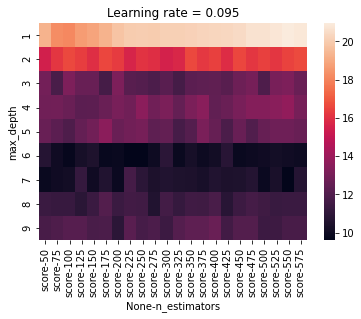

In [ ]:
score_df_095 = pd.DataFrame([[list(gbs_095_means.values())[i], list(gbs_095_means.keys())[i][0], list(gbs_095_means.keys())[i][1]] for i in range(len(gbs_095_means))], columns=['score', 'n_estimators', 'max_depth'])

heatdf = pd.pivot(score_df_095, columns=['n_estimators'], index=['max_depth'], values=['score'])
heatdf
fig = sns.heatmap(heatdf)
plt.title(f'Learning rate = 0.095')

In [ ]:
min_01, min_095, min_std = np.min(score_df_01), np.min(score_df_05), np.min(score_df_std)
print(min_01, min_095, min_std)

score           10.274176
n_estimators    50.000000
max_depth        1.000000
dtype: float64 score            9.587219
n_estimators    50.000000
max_depth        1.000000
dtype: float64 score            9.741154
n_estimators    50.000000
max_depth        1.000000
dtype: float64


####При 50 деревьях и глубине 1, и learning_rate = 0.095:
MSE = 9.587219 < 9.635844078917064

In [ ]:
class nostep_GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        self._n_estimators = n_estimators
        self._max_depth = max_depth
        self._learning_rate = learning_rate
        self._estimators = [{'tree':DecisionTreeRegressor(max_depth=max_depth), 'weight':1} for i in range(n_estimators)]
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        y_new = y
        for i in range(self._n_estimators):
            y_new = y_new - self._fit_predict_tree(i, x, y_new)
        return self

    def _fit_predict_tree(self, i, x, y):
      # Обучаем дерево и возвращаем его предикшн
        self._estimators[i]['tree'] = self._estimators[i]['tree'].fit(x, y)
        return self._learning_rate * self._estimators[i]['tree'].predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.array(sum([estimator['tree'].predict(x)*self._learning_rate for estimator in self._estimators]))
        return y_pred

Побробуем с теми же параметрамими, что и с оптимальным шагом:

In [ ]:
np.random.seed(19052019)
my_gb_no_step = nostep_GradientBoosting(n_estimators=50, max_depth=1, learning_rate=0.095)
my_gb_no_step.fit(X_train, y_train)

#a = my_gb.predict(X_train)

print(mean_squared_error(y_train, my_gb_no_step.predict(X_train)))
mean_squared_error(y_test, my_gb_no_step.predict(X_test))

14.636337074828443


17.466925276058184

Не вышло. Попробуем подвигать параметры на основен heatmap'ов:

In [ ]:
np.random.seed(19052019)
my_gb_no_step = nostep_GradientBoosting(n_estimators=100, max_depth=1, learning_rate=0.095)
my_gb_no_step.fit(X_train, y_train)

#a = my_gb.predict(X_train)

print(mean_squared_error(y_train, my_gb_no_step.predict(X_train)))
mean_squared_error(y_test, my_gb_no_step.predict(X_test))

10.27868451630066


14.852340810947528

In [ ]:
np.random.seed(19052019)
my_gb_no_step = nostep_GradientBoosting(n_estimators=100, max_depth=3, learning_rate=0.095)
my_gb_no_step.fit(X_train, y_train)

#a = my_gb.predict(X_train)

print(mean_squared_error(y_train, my_gb_no_step.predict(X_train)))
mean_squared_error(y_test, my_gb_no_step.predict(X_test))

1.886543735208286


7.945525584069314

Ура! 

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [ ]:
train.head()

Month DayofMonth DayOfWeek  DepTime  ... Origin Dest Distance  dep_delayed_15min
0   c-8       c-21       c-7     1934  ...    ATL  DFW      732                  N
1   c-4       c-20       c-3     1548  ...    PIT  MCO      834                  N
2   c-9        c-2       c-5     1422  ...    RDU  CLE      416                  N
3  c-11       c-25       c-6     1015  ...    DEN  MEM      872                  N
4  c-10        c-7       c-6     1828  ...    MDW  OMA      423                  Y

[5 rows x 9 columns]

In [ ]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.700359377218877

In [ ]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV


In [ ]:
params = {'n_estimators': list(range(100, 750, 25)),
          'depth': list(range(1, 5)),
          'random_seed': [42]
         }
scorer = make_scorer(roc_auc_score)
clf_grid_ = GridSearchCV(estimator=xgb_model, param_grid=params, scoring=scorer, cv=5)

In [ ]:
clf_grid_

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [1, 2, 3, 4],
                         'n_estimators': [100, 125, 150, 175, 200, 225, 250,
                                          275, 300, 

In [ ]:
clf_grid_.fit(X_train_part, y_train_part)
best_param = clf_grid_.best_params_
best_param

{'depth': 1, 'n_estimators': 700, 'random_seed': 42}

In [ ]:
xgb_model_improved = XGBClassifier(max_depth=1, n_estimators=700, random_state=42)
xgb_model_improved.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model_improved.predict_proba(X_valid)[:, 1])

0.693590177902002

Этого мало. Задействуем остальные признаки при помощи LabelEncoder

In [ ]:
import sklearn.preprocessing
le = sklearn.preprocessing.OneHotEncoder()

y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})
train = train.drop('dep_delayed_15min', axis=1)
train = pd.get_dummies(train, columns=train.select_dtypes('object').columns.values)

#X_train_encoded = X_train[X_train.select_dtypes('object').columns.values].apply(le.fit_transform)
#X_test_encoded = X_valid[X_valid.select_dtypes('object').columns.values].apply(le.fit_transform)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y_train, test_size=0.3, random_state=42)

In [ ]:
pip install sklearn

In [ ]:
xgb_model_improved_encoded = XGBClassifier(random_state=42)
xgb_model_improved_encoded.fit(X_train.values, y_train)
roc_auc_score(y_valid, xgb_model_improved_encoded.predict_proba(X_valid.values)[:, 1])

0.7244022116474584

In [ ]:
xgb_model_improved_encoded = XGBClassifier(n_estimators=700, learning_rate=0.095, random_state=1)
xgb_model_improved_encoded.fit(X_train.values, y_train)
roc_auc_score(y_valid, xgb_model_improved_encoded.predict_proba(X_valid.values)[:, 1])

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [ ]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance
import copy

In [ ]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self._eps = eps
        self._min_samples = min_samples
        self.clusters = {}

    def _range_query(self, x, X, reachable_matrix):
        """Возвращает точки на расстоянии <= eps от x"""
        return np.arange(X.shape[0])[reachable_matrix[x, :] == 1]

    def _get_reachable_matrix(self, X, eps):
      weighted_matrix = distance.squareform(distance.pdist(X, 'euclidean'))
      incidence_matrix_copy = weighted_matrix < self._eps
      sums = np.apply_along_axis(np.sum, 0, incidence_matrix_copy) < self._min_samples

      for mask in range(sums.shape[0]):
        if sums[mask]:
          incidence_matrix_copy[mask, :] = 0
      incidence_matrix = incidence_matrix_copy.dot(incidence_matrix_copy) >= 1
      while True:
          if np.all(incidence_matrix_copy == incidence_matrix):
            break
          incidence_matrix_copy = incidence_matrix
          incidence_matrix = (incidence_matrix + incidence_matrix.dot(incidence_matrix)) >= 1
      print(np.all(incidence_matrix))
      print(incidence_matrix)
      return incidence_matrix
      

    def fit_predict(self, X):
        prediction = pd.Series(['Uncategorised' for i in range(X.shape[0])], index=range(X.shape[0]))
        reachable_matrix = self._get_reachable_matrix(X, self._eps)
        for i in range(X.shape[0]):
          if sum(reachable_matrix[i, :]) < self._min_samples:
            continue
          elif prediction[i] != 'Uncategorised':
              self.clusters[f'cluster {prediction[i]}'].union(self._range_query(i, X, reachable_matrix))
              prediction[list(self._range_query(i, X, reachable_matrix))] = prediction.iloc[i]
          else:
            self._grow_cluster(i, self._range_query(i, X, reachable_matrix))
            prediction[list(self.clusters[f'cluster {i}'])] = i
        return prediction.replace("Uncategorised", -1)
        

    def _grow_cluster(self, root, neighbours):
        self.clusters[f'cluster {root}'] = set(neighbours)


Проверим себя на простом примере:

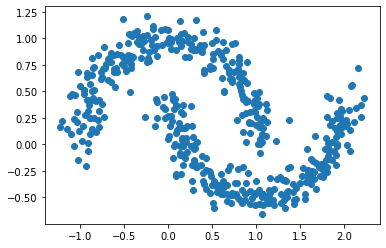

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [ ]:
print(X)

Кластеризуйте это с помощью своей версии DBSCAN:

In [ ]:
my_dbscan = dbscan(eps=0.2, min_samples=10)
pred = my_dbscan.fit_predict(X)

False
[[ True False False ...  True  True  True]
 [False False False ... False False False]
 [False  True  True ... False False False]
 ...
 [ True False False ...  True  True  True]
 [ True False False ...  True  True  True]
 [ True False False ...  True  True  True]]


In [ ]:
my_dbscan.clusters.keys()

dict_keys(['cluster 0', 'cluster 2'])

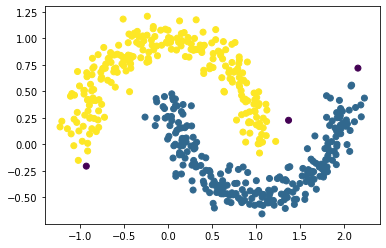

In [ ]:
plt.scatter(X[:,0], X[:,1], c=pred)
plt.show()

Референс:

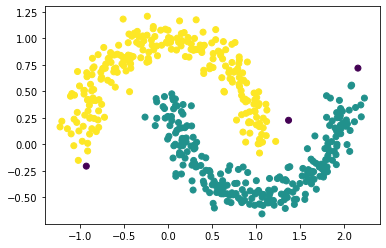

In [ ]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [ ]:
import sklearn.datasets as dt

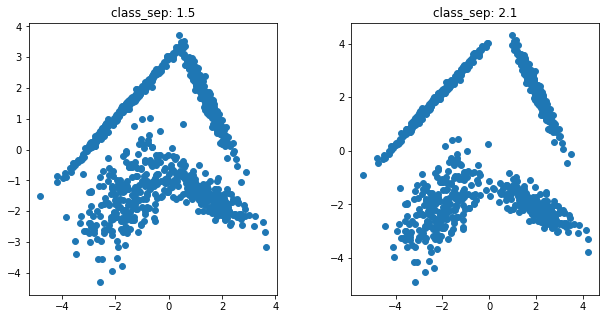

In [ ]:
x = {}
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt_ind_list = np.arange(2)+131

for class_sep, plt_ind in zip([1.5, 2.1],plt_ind_list):
    x[class_sep], _ = dt.make_classification(n_samples=1000,
                                 n_features=2,
                                 n_repeated=0,
                                 class_sep=class_sep,
                                 n_redundant=0,
                                 random_state=3)
    
    plt.subplot(plt_ind)
    my_scatter_plot = plt.scatter(x[class_sep][:,0],
                                  x[class_sep][:,1],
                                  vmin=min(y),
                                  vmax=max(y),
                                  s=35)
    plt.title('class_sep: '+str(class_sep))

fig.subplots_adjust(hspace=0.3,wspace=.3)
plt.show()

In [ ]:
my_dbscan = dbscan(eps=0.5, min_samples=15)
pred = my_dbscan.fit_predict(x[1.5])

In [ ]:
my_dbscan.clusters.keys()

dict_keys(['cluster 0', 'cluster 3'])

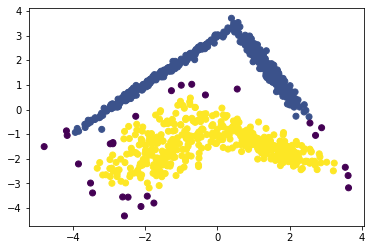

In [ ]:
plt.scatter(x[1.5][:,0], x[1.5][:,1], c=pred)
plt.show()

In [ ]:
my_dbscan = dbscan(eps=0.5, min_samples=15)
pred = my_dbscan.fit_predict(x[2.1])

False
[[ True  True False ... False False False]
 [ True  True False ... False False False]
 [False False  True ...  True  True False]
 ...
 [False False  True ...  True  True False]
 [False False  True ...  True  True False]
 [False False False ... False False  True]]


In [ ]:
my_dbscan.clusters.keys()

dict_keys(['cluster 0', 'cluster 2', 'cluster 3', 'cluster 7'])

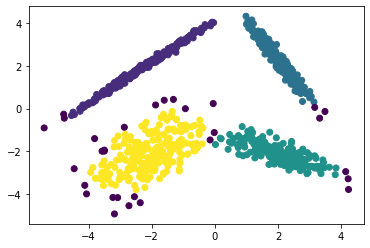

In [ ]:
plt.scatter(x[2.1][:,0], x[2.1][:,1], c=pred)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [ ]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 6.48 ms, sys: 2.01 ms, total: 8.48 ms
Wall time: 12.2 ms


In [ ]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 1.57 s, sys: 23.6 ms, total: 1.6 s
Wall time: 1.57 s


In [ ]:
(1570/12.2 - 1570*0.03) < 100

True